In [9]:
import mne
import os
import os.path as op
import numpy as np
import pickle
from warnings import filterwarnings
from sys import argv
import matplotlib.pyplot as plt
from stormdb.access import Query
import pandas as pd
from src.preprocessing import WM_epoching, main_task_events_fun
import src.decoding_functions as dfun
import importlib
importlib.reload(dfun)

filterwarnings("ignore", category=DeprecationWarning)

In [2]:
## Define relevant variables
# Project info
project = 'MINDLAB2020_MEG-AuditoryPatternRecognition'
project_dir = '/projects/' + project
os.environ['MINDLABPROJ']= project
os.environ['MNE_ROOT']='~/miniconda3/envs/mne'
os.environ['MESA_GL_VERSION_OVERRIDE'] = '3.2'

#Paths
raw_path = project_dir + '/scratch/maxfiltered_data/tsss_st16_corr96'
ica_path = project_dir + '/scratch/working_memory/ICA'
avg_path = project_dir + '/scratch/working_memory/averages'
log_path = project_dir + '/misc/working_memory_logs'

subjects_dir = project_dir + '/scratch/fs_subjects_dir'
fwd_path = project_dir + '/scratch/forward_models'

# Subject info:
qy = Query(project)
subs = qy.get_subjects()
scode = 24
# if len(argv) > 1:
#     scode = int(argv[1])

#Other variables
sub = subs[scode-1] #'0002_BYG'#'0002_BYG'#'0008_HMD'#'0002_BYG'
conds_orig = ['main','inv'] #  ['mainv2','invv2']
conds = ['maintenance','manipulation']
lnames = ['recognize','invert']

In [3]:
#Epoch data
tmin = -.1 #epoch start
tmax = 6.5 #epoch end
reject = dict(mag = 4e-12, grad = 4000e-13) # rejection criteria

# Initialize
epochs = {}
print('\n epoching \n')
for cidx, c in enumerate(conds_orig):
    nc = conds[cidx] # new condition name
    
    # Files to retrieve
    fname = os.path.join(raw_path, sub, c + '_raw_tsss.fif')
    icaname = os.path.join(ica_path,sub, c + '_raw_tsss-ica.fif')
    lfname = op.join(log_path, sub[0:4] + '_' + lnames[cidx] + '_MEG.csv')
    
    #Epoching proper:
    epochs[nc] = WM_epoching(data_path = fname, ica_path = icaname, tmin = -1, tmax = 4,
                                l_freq = None, h_freq = None, resample = 100, bads = [],
                                baseline = None, notch_filter = 50,
                                events_fun = main_task_events_fun, 
                                events_fun_kwargs = {'cond': nc, 'lfname': lfname},
                                reject=reject)


 epoching 

Opening raw data file /projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/maxfiltered_data/tsss_st16_corr96/0024_JSV/main_raw_tsss.fif...
    Range : 9000 ... 581999 =      9.000 ...   581.999 secs
Ready.
Reading 0 ... 572999  =      0.000 ...   572.999 secs...
Reading /projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/working_memory/ICA/0024_JSV/main_raw_tsss-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 2 ICA components
    Projecting back using 306 PCA components
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.6

In [4]:
# Recode melodies to 0 and 1
for e in epochs:
    epochs[e].events[:,2] = np.array([((ll // 10) - 1) % 2 for ll in epochs[e].events[:,2]])

In [5]:
# Perform decoding
smooth_kwargs = {'tstep': .025, 'twin': .05}
gen, patterns, filters, scores, times = dfun.WM_time_gen_classify(epochs, mode='sensor', inv = None, score = True,
                                                             n_features = 'all', twindows = [-.1,4], l_freq=None, h_freq = None,
                                                             smooth = smooth_kwargs, save_filters=None, save_scores = None,
                                                             save_gen=None, save_patterns=None)

fitting  maintenance


  0%|          | Fitting GeneralizingEstimator : 0/163 [00:00<?,       ?it/s]

extractig patterns and filters
scoring  maintenance_from_maintenance


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
  4%|▍         | Fitting GeneralizingEstimator : 7/163 [00:00<00:02,   67.36it/s]/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: 

scoring  manipulation_from_maintenance


100%|██████████| Scoring GeneralizingEstimator : 26569/26569 [01:22<00:00,  321.46it/s]
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.6min finished


  0%|          | Scoring GeneralizingEstimator : 0/26569 [00:00<?,       ?it/s]

fitting  manipulation


  0%|          | Fitting GeneralizingEstimator : 0/163 [00:00<?,       ?it/s]

extractig patterns and filters
scoring  maintenance_from_manipulation


  0%|          | Scoring GeneralizingEstimator : 0/26569 [00:00<?,       ?it/s]

scoring  manipulation_from_manipulation


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if Loo

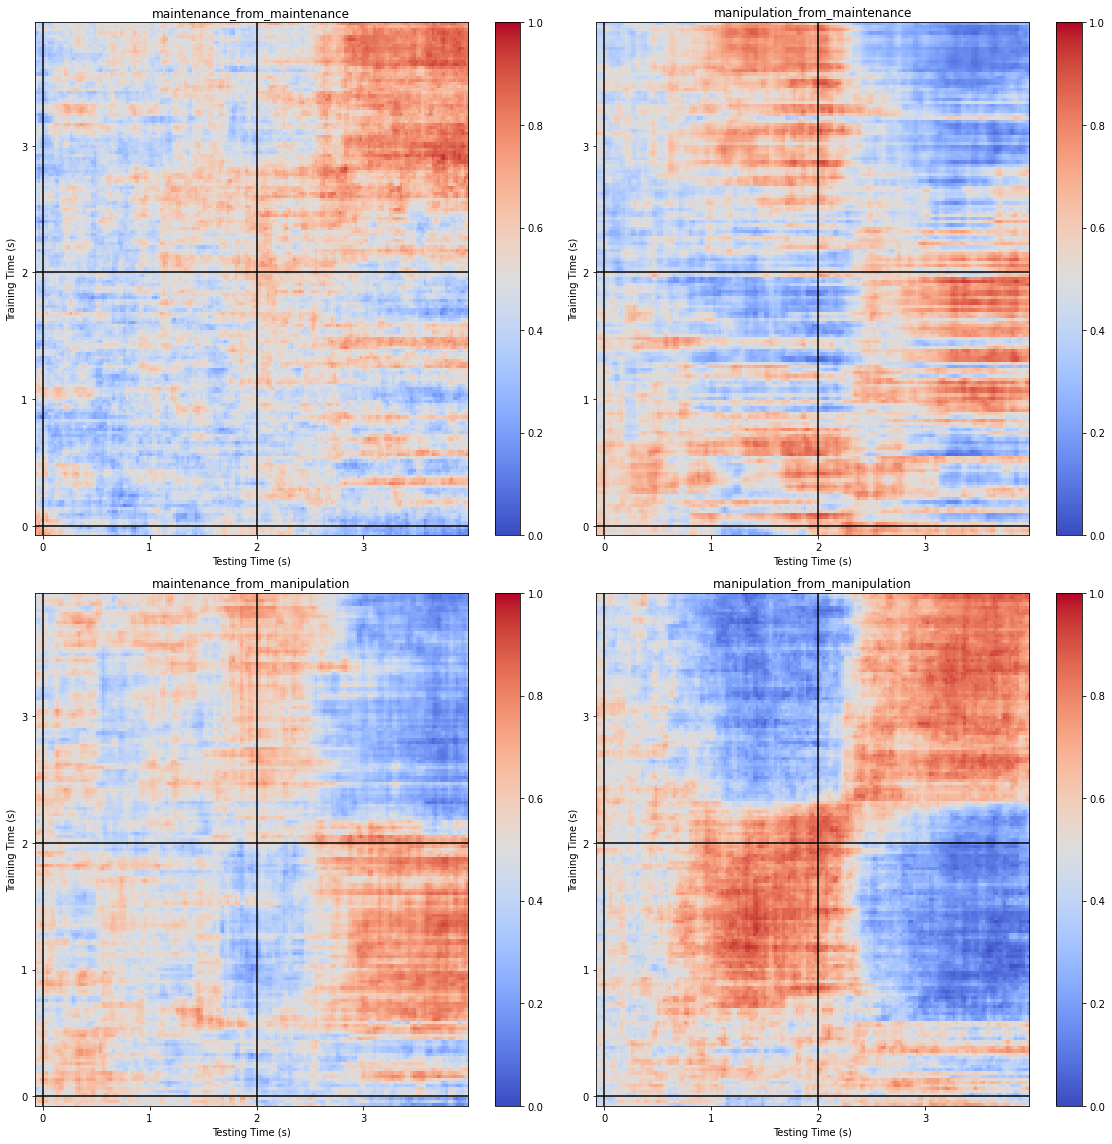

In [10]:
dfun.plot_time_gen_accuracy(scores, times, nrows=2, ncols=2,vlines=[2],hlines=[2],
                            savefig=None, vmin=0, vmax=1)